In [ ]:
!pip install pytorch-lightning scikit-learn plotly

Anomaly detection (or outlier detection) is one of the many tasks that keep Data Scientists awake at night when then need to satisfy the business needs. No matter whether the data in well structured (like user events) or unstructured (like text or images), there are plenty of methods that allow to tackle this problem and it's diffictult to choose one. Sometimes, it's even difficult to properly define, what an anomaly is - but that's not the part of this post main focus. Some of the most popular methods for anomaly detection are:
* statistical methods - like three-sigma rule and regression models
* classical machine learning methods - like one-class SVM, Isolation Forests or clustering-based methods (e.g. kNN)
* deep learning methods - like autoencoders and deep forecasting models (e.g. LSTMs for time series)

In this post I will focus on a single method called <strong>Robust Subspace Recovery Layer for Unsupervised Anomaly Detection</strong> (<a href="https://arxiv.org/abs/1904.00152" target="blank">https://arxiv.org/abs/1904.00152</a>) which is an extension of the autoencoder-based unsupervised anomnaly detection method for data of any domain.

## TL;DR
Implementation of <strong>RSR Layer</strong> and RSR Autoencoder in PyTorch.

> Note:
This post and my implementation does not reproduce RSR Layer paper. I only explain the general idea and provide minimal working code as a form of proof-of-concept.

## General idea behind Robust Space Recovery Layer
Autoencoders were used for the anomaly detection much earlier than this (RSR) paper appeared. To use autoencoder in a setting of anomaly detection, one treats "normal" examples (inliners) as the ones that have low reconstruction error and other which have high reconstruction error are treated as outliers. Although the idea is fairly easy to understand and implement, the problem lies in the fact that in order for autoencoder to work properly in this setting (i.e. to detect the outliers) the training data should be clean (or have really small fraction of the outliers). In the real world it's highly unlikely for the input data to be free of any anomalies and even if Data Scientists could label and filter the data (given they know what an anomaly in the given dataset is) it simply won't scale.

The *Robust Subspace Recovery Layer* paper tries to adress this issue by incorporating the RSR Layer into autoencoders. It's clearly stated that this method does not compete with semi-supervised or supervised anomaly detection setting, but shows its strenght in the unsupervised setting.

### What is the RSR Layer?
The RSR Layer itself is just an additional layer in the nerual network with specific properties. It maps one representation (embedding obtained from the encoder) into another **low-dimensional representation that is outlier-robust**.

Let's say that *D* (upper case D) is the dimension of the embedding from the encoder. The assumption in the paper is that the "normal" data lies within *d*-dimensional (lower case d) manifold ("subspace") of the original embedding, which means that *d < D*.

Please refeer to the paper to obtain more details and the full explanation and analysis. At this point you should know enough to proceed to the implementation section.

## How to implement the RSR Layer in PyTorch?
As RSR Layer is just a linear mapping, there are only a few things needed:
1. The dimension *D* from the encoder's output.
2. The dimension *d* which is a direct property of the RSR Layer (and probably requires a hyperparamer search to set it properly).
3. Proper initialization of the linear mapping weights (the optimization goal of the RSR Autoencoder enforces that, so it's better to start with a set of weights that already fulfill this constraint).

The implementation of the layer itself is straightforward.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class RSRLayer(nn.Module):
    def __init__(self, d:int, D: int):
        super().__init__()
        self.d = d
        self.D = D
        self.A = nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, D)))

    def forward(self, z):
        # z is the output from the encoder
        z_hat = self.A @ z.view(z.size(0), self.D, 1)
        return z_hat.squeeze(2)

The next piece to obtain RSR Autoencoder in PyTorch is to implement RSR Loss as per paper's equation (4):
<img src="./rsrloss.gif" alt="RSR Loss PyTorch RSRLoss" title="RSR Loss PyTorch RSRLoss"/>
The first term is enforces the RSR Layer projection to be robust and the second term enforces the projection to be orthogonal. Refeer to the paper for the motivation behind this loss as it it out of scope for this blog post.

Nearly op-for-op (math-to-PyTorch) implementation of this loss looks like this:

In [ ]:
class RSRLoss(nn.Module):
    def __init__(self, lambda1, lambda2, d, D):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.d = d
        self.D = D
        self.register_buffer(
            "Id", torch.eye(d)
        )

    def forward(self, z, A):
        z_hat = A @ z.view(z.size(0), self.D, 1)
        AtAz = (A.T @ z_hat).squeeze(2)
        term1 = torch.sum(
            torch.norm(z - AtAz, p=2)
        )

        term2 = torch.norm(
            A @ A.T - self.Id, p=2
        ) ** 2

        return self.lambda1 * term1 + self.lambda2 * term2

Lastly, the standard L1/L2 reconstruction loss is replaced by the *l<sub>2,p</sub>-norm* based loss (again, the paper relies on "more robustness", wiki: <a href="https://en.wikipedia.org/wiki/Matrix_norm#L2,1_and_Lp,q_norms" target="blank">https://en.wikipedia.org/wiki/Matrix_norm#L2,1_and_Lp,q_norms</a>). In practice, the paper uses *l<sub>2,1</sub>* version.
<img src="./l2ploss.gif" alt="L2,p loss PyTorch" title="L2,p loss PyTorch"/>

In [ ]:
class L2p_Loss(nn.Module):
    def __init__(self, p=1.0):
        super().__init__()
        self.p = p
  
    def forward(self, y_hat, y):
        return torch.sum(
            torch.pow(
                torch.norm(y - y_hat, p=2), self.p
            )
        )

## RSR Auto Encoder in PyTorch
In order to see the RSR Layer in practice, the RSR Autoencoder needs to be implemented.

> **Important**<br/>
The following RSR Autoencoder implementation is only a minimal, working proof of concept. As I've stated earlier, the intent of this blog post is to implement the RSR Layers and play around with them, not reach the SOTA or reproduce the paper's results. Feel free to use my code and plug-in your encoder and decoder networks.

In [ ]:
class RSRAutoEncoder(nn.Module):
    def __init__(self, input_dim, d, D):
        super().__init__()
        # Put your encoder network here, remember about the output D-dimension
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim // 4),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 4, D)
        )

        self.rsr = RSRLayer(d, D)

        # Put your decoder network here, rembember about the input d-dimension
        self.decoder = nn.Sequential(
          nn.Linear(d, D),
          nn.LeakyReLU(),
          nn.Linear(D, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim)
        )
    
    def forward(self, x):
        enc = self.encoder(x) # obtain the embedding from the encoder
        latent = self.rsr(enc) # RSR manifold
        dec = self.decoder(latent) # obtain the representation in the input space
        return enc, dec, latent, self.rsr.A

## Training the autoencoder with RSR Layer in PyTorch (& PyTorch Lightning)
As usual, I use PyTorch Lightning to skip the training boilerplate.

In [ ]:
import pytorch_lightning as pl

In [ ]:
pl.seed_everything(666)

Global seed set to 666


666

### Corrupted MNIST dataset (with outliers)
For this proof-of-concept I will be using a corrupted version of MNIST dataset, that contains single class as "normal" data and a few other, that will be treated as outliers.

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

mnist = MNIST(".", download=True, transform=ToTensor())

In [ ]:
class RSRDs(torch.utils.data.Dataset):
    def __init__(self, target_class, other_classes, n_examples_per_other):
        super().__init__()
        self.mnist = MNIST(".", download=True, transform=ToTensor())
        self.target_indices = (self.mnist.targets == target_class).nonzero().flatten()
        
        other = []
        for other_class in other_classes:
            other.extend(
                (self.mnist.targets == other_class).nonzero().flatten()[:n_examples_per_other]
            )
        self.other_indices = torch.tensor(other)
        self.all_indices = torch.cat([self.other_indices, self.target_indices])
        print(f"Targets: {self.target_indices.size(0)}")
        print(f"Others : {self.other_indices.size(0)}")
    
    def __getitem__(self, idx):
        actual_idx = self.all_indices[idx].item()
        return self.mnist[actual_idx]
    
    def __len__(self):
        return self.all_indices.size(0)

In [ ]:
ds = RSRDs(target_class=4, other_classes=(0, 1, 2, 8), n_examples_per_other=100)

Targets: 5842
Others : 400


In [ ]:
ds[0][0].shape, ds[0][1]

(torch.Size([1, 28, 28]), 0)

### RSRAutoEncoder module in PyTorch Lightning
The following module combines all of the pieces together:
1. RSR Autoencoder with RSR Layer inside,
2. L2p reconstruction loss,
3. RSR Loss.

In [ ]:
class RSRAE(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.ae = RSRAutoEncoder(
            self.hparams.input_dim, 
            self.hparams.d, 
            self.hparams.D)
        self.reconstruction_loss = L2p_Loss(p=1.0)
        self.rsr_loss = RSRLoss(self.hparams.lambda1, self.hparams.lambda2, self.hparams.d, self.hparams.D)
  
    def forward(self, x):
        return self.ae(x)
  
    def training_step(self, batch, batch_idx):
        X, _ = batch
        x = X.view(X.size(0), -1)
        enc, dec, latent, A = self.ae(x)

        rec_loss = self.reconstruction_loss(torch.sigmoid(dec), x)
        rsr_loss = self.rsr_loss(enc, A)
        loss = rec_loss + rsr_loss
        
        # log some usefull stuff
        self.log("reconstruction_loss", rec_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        self.log("rsr_loss", rsr_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        return {"loss": loss}

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        # Fast.AI's best practices :)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=self.hparams.lr, 
                                                        epochs=self.hparams.epochs, 
                                                        steps_per_epoch=self.hparams.steps_per_epoch)
        return [opt], [{
            "scheduler": scheduler,
            "interval": "step"
        }]


In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
hparams = dict(
    d=16,
    D=128,
    input_dim=28*28,
    # Peak learning rate
    lr=0.01,
    # Configuration for the OneCycleLR scheduler
    epochs=150,
    steps_per_epoch=len(dl),
    # lambda coefficients from RSR Loss
    lambda1=1.0,
    lambda2=1.0,
)
model = RSRAE(hparams)
model

RSRAE(
  (ae): RSRAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=392, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=392, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=196, out_features=128, bias=True)
    )
    (rsr): RSRLayer()
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=392, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=392, out_features=784, bias=True)
    )
  )
  (reconstruction_loss): L2p_Loss()
  (rsr_loss): RSRLoss()
)

In [ ]:
trainer = pl.Trainer(max_epochs=model.hparams.epochs, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type           | Params
-------------------------------------------------------
0 | ae                  | RSRAutoEncoder | 772 K 
1 | reconstruction_loss | L2p_Loss       | 0     
2 | rsr_loss            | RSRLoss        | 0     
-------------------------------------------------------
772 K     Trainable params
0         Non-trainable params
772 K     Total params
3.091     Total estimated model params size (MB)


1

## Analysing RSRAutoEncoder outputs
First, let's check the general autoencoder reconstuction.

In [ ]:
model.freeze()
from torchvision.transforms import functional as tvf
from torchvision.utils import make_grid
def reconstruct(x, model):
    enc, x_hat, latent, A = model(x.view(1, -1))
    # x_img = tvf.to_pil_image(
    #     x_hat.squeeze(0).view(1, 28, 28)
    # )
    x_hat = torch.sigmoid(x_hat)
    return tvf.to_pil_image(
      make_grid([x_hat.squeeze(0).view(1, 28, 28), x])
    )

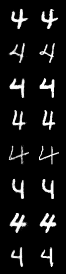

In [ ]:
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in torch.randint(0, len(ds), (8, ))], nrow=1)
)

Most of the images seem OK to me, given how simple the model is.

Now let's look at the RSR embedding space projected into 3D using PCA.

In [ ]:
import pandas as pd
rsr_embeddings = []
classes = []
errors = []
for batch in iter(DataLoader(ds, batch_size=64, shuffle=False)):
    X, cl = batch
    x = X.view(X.size(0), -1)
    enc, x_hat, latent, A = model(x)
    rsr_embeddings.append(latent)
    classes.extend(cl.numpy())
    for i in range(X.size(0)):
        rec_error = L2p_Loss()(torch.sigmoid(x_hat[i]).unsqueeze(0), x[i].unsqueeze(0))
        errors.append(float(rec_error.numpy()))
        
all_embs = torch.vstack(rsr_embeddings)
df = pd.DataFrame(all_embs.numpy(), columns=["x", "y", "z"] + [f"dim_{i}" for i in range(hparams["d"] - 3)])
df.loc[:, "class"] = classes
df.loc[:, "errors"] = errors

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
rsr_3d = pd.DataFrame(pca.fit_transform(all_embs), columns=["x", "y", "z"])
rsr_3d.loc[:, "class"] = classes

In [ ]:
import plotly.express as px
import plotly
df = df
fig = px.scatter_3d(df, x='x', y='y', z='z',
               symbol="class", color="class", opacity=0.95)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Indeed, most of the *4* (the main class - inliners) reside in the center of the space, with other classes positioned further away from the center. 

### Unsupervised anomaly detection using RSR AutoEncoder
Now let's see if it works as the authors of the paper claim - whether the data points with high reconstruction error are really outliers.

In [ ]:
df.errors.describe()

count    6242.000000
mean        1.531033
std         0.288761
min         0.449000
25%         1.335255
50%         1.497706
75%         1.681182
max         3.499686
Name: errors, dtype: float64

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: errors, dtype: object

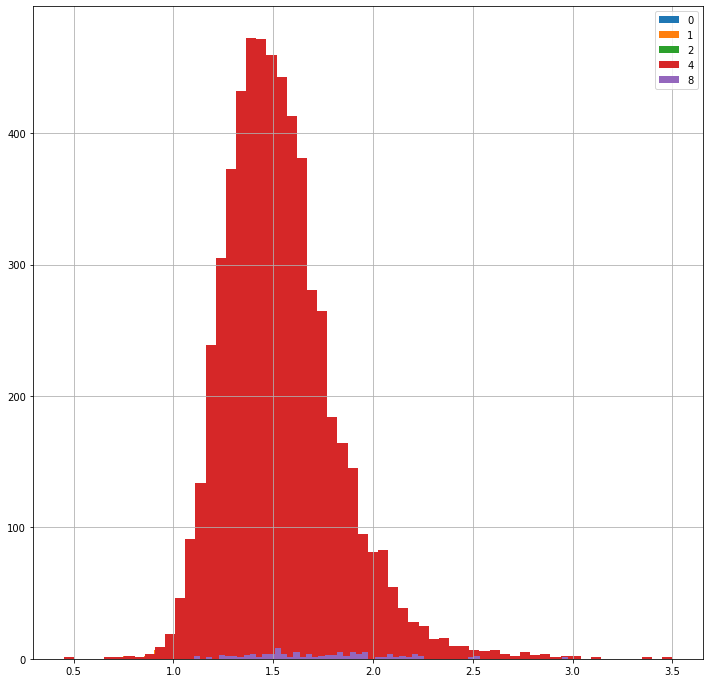

In [ ]:
df.groupby("class").errors.hist(legend=True, bins=60, figsize=(12, 12))

The reconstruction loss is centered around `1.5` with a tail spreading up to `3.46`. What are the data points with the largest errors?

In [ ]:
lowest_mistakes = df.sort_values(by="errors", ascending=True).head(60).loc[:, ["errors", "class"]]
highest_mistakes = df.sort_values(by="errors", ascending=False).head(60).loc[:, ["errors", "class"]]
highest_mistakes.head(10)

,errors,class
5917,3.499686,4
1619,3.351312,4
983,3.114273,4
1312,2.996117,4
6017,2.994786,4
3515,2.982858,4
335,2.976048,8
5809,2.947206,4
2201,2.908396,4
5834,2.884266,4


It seems really odd at first, as I've expected all the non-4 classes to have the largest errors. But let's carefully look at the actual results:

Images with the highest reconsturction loss


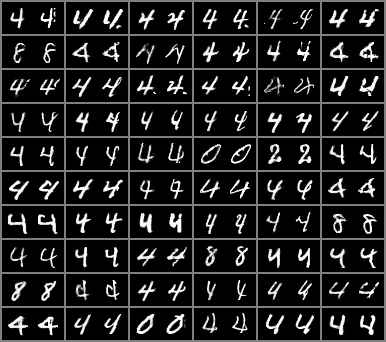

In [ ]:
print("Images with the highest reconsturction loss")
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in highest_mistakes.index], nrow=6,
             pad_value=0.5)
)

Images with the lowest reconsturction loss


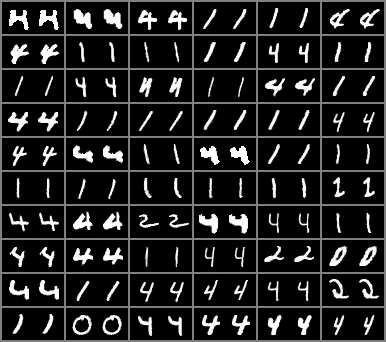

In [ ]:
print("Images with the lowest reconsturction loss")
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in lowest_mistakes.index], nrow=6,
             pad_value=0.5)
)

Now it's much clearer - the model found the manifold that separates the images into the "normal" ones - that in this setting seem like more smooth ones with clean curves - and the outliers that are rather sharp, contain some random artifacts (which are anomalies IMHO) and usually seem slightly malformed. Given the model simplicity and the setup, it looks to me like a good starting point for the unsupervised anomaly detection.

## Summary
I hope you find this post useful and it will help you to quickly get started with **RSR Layer** and **unsupervised anomaly detection in PyTorch.** Do not hesistate to comment and share!

## Additional links & resources
* Jupyter notebook for this post in Google Colab
* GitHub repo with this notebook: https://github.com/marrrcin/rsrlayer-pytorch
